In [1]:
import os
os.chdir('../')

In [2]:
import normet.intervention as interv

In [27]:
import pandas as pd
import numpy as np

In [178]:
df=pd.read_excel(r'./normet/datasets/Intervention/ChinaAQ_Weekly.xlsx',parse_dates=['date'])

In [179]:
df=df.query(f"date>='2015-05-01'").query(f"date<'2016-04-30'")

In [180]:
df=df[df['ID'].isin([ '2+26 cities',"Dongguan", "Zhongshan" , "Foshan", "Beihai"
               , "Nanning","Nanchang" , "Xiamen", "Taizhou" 
               , "Ningbo","Guangzhou" , "Huizhou", "Hangzhou" 
               , "Liuzhou", "Shantou", "Jiangmen", "Heyuan", "Quanzhou","Haikou" , "Shenzhen", "Wenzhou", "Huzhou"
               , "Zhuhai", "Fuzhou", "Shaoxing", "Zhaoqing","Zhoushan"  
               , "Quzhou", "Jinhua", "Shaoguan" , "Sanya"
               , "Jieyang" , "Meizhou", "Shanwei" 
               , "Zhanjiang" , "Chaozhou", "Maoming" , "Yangjiang"])]

In [181]:
df=df[['date','ID','SO2wn']]

In [182]:
df['treated']=df['ID']=='2+26 cities'

In [183]:
df['after_treatment']=df['date']>'2015-10-23'

In [184]:
def synthetic_control(data, outcome_col, year_col, state_col, treat_col, post_col):
    
    x_pre_control = (data
                     .query(f"~{treat_col}")
                     .query(f"~{post_col}")
                     .pivot(year_col, state_col, outcome_col)
                     .values)
    
    y_pre_treat_mean = (data
                        .query(f"~{post_col}")
                        .query(f"{treat_col}")
                        .groupby(year_col)
                        [outcome_col]
                        .mean())
    
    w = cp.Variable(x_pre_control.shape[1])
    objective = cp.Minimize(cp.sum_squares(x_pre_control@w - y_pre_treat_mean.values))
    constraints = [cp.sum(w) == 1, w >= 0]
    
    problem = cp.Problem(objective, constraints)
    problem.solve(verbose=False)
    
    sc = (data
          .query(f"~{treat_col}")
          .pivot(year_col, state_col, outcome_col)
          .values) @ w.value
    
    df=(data
            .query(f"{treat_col}")[[year_col, state_col, outcome_col]]
            .assign(synthetic=sc))
    
    return df

In [185]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from toolz import reduce, partial
from scipy.optimize import fmin_slsqp
import statsmodels.formula.api as smf
import cvxpy as cp
from joblib import Parallel, delayed

In [186]:
xx=synthetic_control(df,'SO2wn','date','ID','treated','after_treatment').set_index('date')

<Axes: xlabel='date'>

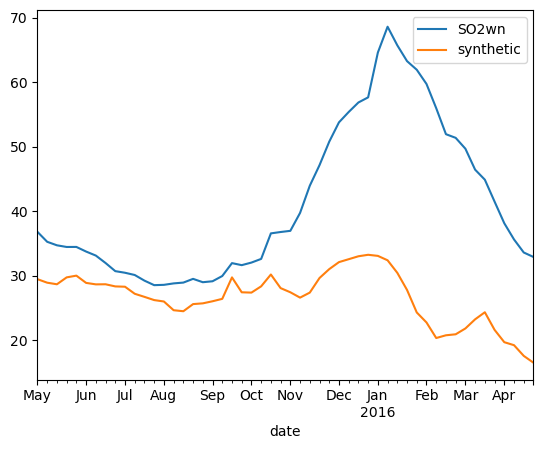

In [187]:
xx[['SO2wn','synthetic']].plot()